In [1]:
!nvidia-smi

Mon Feb 21 15:14:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Prepareing Dataset

In [74]:
!cp "/content/drive/MyDrive/div2k-dataset.zip" "/content/"

In [ ]:
!unzip *.zip && rm -rf *.zip

In [77]:
import glob
images_path = glob.glob("/content/DIV2K_train_HR/DIV2K_train_HR/*.png") + glob.glob("/content/DIV2K_valid_HR/DIV2K_valid_HR/*.png")
print("Number of Images: {}".format(len(images_path)))

Number of Images: 900


In [86]:
from PIL import Image
from random import randrange

hr_folder = "hrimages"
lr_folder = "lrimages"

!rm -rf "hrimages"
!rm -rf "lrimages"
!mkdir "hrimages"
!mkdir "lrimages"

In [87]:
def get_low_resolution(image, img_name, img_id):
  filename = f"{lr_folder}/{img_name}_{img_id}.jpg"
  image = image.resize((80, 80))
  image = image.resize((256, 256))
  image.save(filename)
  print("Low Resolution Saved: {}".format(filename))

In [88]:
def get_high_resolution(image):
  img = Image.open(image)  
  x, y = img.size

  matrix = 256
  sample = 15
  img_id = 1
  sample_list = []

  for i in range(sample):
      x1 = randrange(0, x - matrix)
      y1 = randrange(0, y - matrix)
      sample_list.append(img.crop((x1, y1, x1 + matrix, y1 + matrix)))
  
  for sample_img in sample_list:
      img_name = image.split("/")[-1].split(".")[0]
      filename = f"{hr_folder}/{img_name}_{img_id}.jpg"
      get_low_resolution(sample_img, img_name, img_id)
      sample_img.save(filename)
      img_id += 1
      print("High Resolution Saved: {}".format(filename))

In [ ]:
for image_path in images_path:
  get_high_resolution(image_path)

In [90]:
import os
print("Number of High Resolution Images: {}".format(len(os.listdir("hrimages/"))))
print("Number of Low Resolution Images: {}".format(len(os.listdir("lrimages/"))))

Number of High Resolution Images: 13500
Number of Low Resolution Images: 13500


In [92]:
!rm -rf "hr_lr_images"
!mkdir "hr_lr_images"

In [ ]:
!zip -r "/content/hr_lr_images.zip" "/content/hr_lr_images"

In [1]:
import matplotlib.pyplot as plt

# defining function to plot images pair
def plot_images(hrimage, lrimage):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(hrimage)
    plt.subplot(1,3,2)
    plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(lrimage)
   
    plt.show()

In [ ]:
import cv2

hr_image = cv2.cvtColor(cv2.imread("/content/hrimages/vaulted-cellar-247391_10.jpg"), cv2.COLOR_BGR2RGB)
lr_image = cv2.cvtColor(cv2.imread("/content/lrimages/vaulted-cellar-247391_10.jpg"), cv2.COLOR_BGR2RGB)
plot_images(hr_image, lr_image)
print(hr_image.shape, lr_image.shape)

In [94]:
!cp "/content/hr_lr_images.zip" "/content/drive/MyDrive"

In [3]:
!cp "/content/drive/MyDrive/hr_lr_images.zip" "/content/"

In [ ]:
!unzip *.zip && rm -rf *.zip

#DataGenerator

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2

class LTHAutoEncoderDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, LOW_RES_PATH, HIGH_RES_PATH,
                 batch_size,
                 input_size=(256, 256, 3)):
        self.df = paths.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.LOW_RES_PATH = LOW_RES_PATH
        self.HIGH_RES_PATH = HIGH_RES_PATH
        
        self.n = len(self.df)
        self.m = 0
        self.max = self.__len__()
    
    def __len__(self):
        return int(len(self.df) / float(self.batch_size))
    
    def __get_low(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        image_arr = image_arr / 255.0
        return image_arr

    def __get_high(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        image_arr = image_arr / 255.0
        return image_arr
    
    def __get_X_data(self, batches):
        # Generates data containing batch_size samples
        X_batch = np.asarray([self.__get_low(x, self.input_size) for x in batches])
        return X_batch

    def __get_Y_data(self, batches):
        # Generates data containing batch_size samples
        Y_batch = np.asarray([self.__get_high(x, self.input_size) for x in batches])
        return Y_batch

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        low_res_batches = [os.path.join(self.LOW_RES_PATH, img) for img in batches]
        high_res_batches = [os.path.join(self.HIGH_RES_PATH, img) for img in batches]
        X = self.__get_X_data(low_res_batches)
        Y = self.__get_Y_data(high_res_batches)
        return X, Y

    def __next__(self):
        if self.m >= self.max:
            self.m = 0
        x, y = self.__getitem__(self.m)
        self.m += 1
        return x, y

In [ ]:
!pip install split-folders

In [8]:
import splitfolders
splitfolders.ratio("/content/content/hr_lr_images", output="/content/output", seed=1337, ratio=(.8, 0.15,0.05)) 

Copying files: 27000 files [00:06, 4170.13 files/s]


In [2]:
EPOCHS = 100
BATCH_SIZE = 32
IMAGE_SHAPE = (256, 256, 3)

In [3]:
TR_LOW_IMAGES_PATH = "/content/output/train/lrimages"
TR_HIGH_IMAGES_PATH = "/content/output/train/hrimages"
TR_images_paths = os.listdir(TR_LOW_IMAGES_PATH)
train_generator = LTHAutoEncoderDataGenerator(TR_images_paths, TR_LOW_IMAGES_PATH, TR_HIGH_IMAGES_PATH, batch_size=BATCH_SIZE, input_size=IMAGE_SHAPE)

In [4]:
TE_LOW_IMAGES_PATH = "/content/output/test/lrimages"
TE_HIGH_IMAGES_PATH = "/content/output/test/hrimages"
TE_images_paths = os.listdir(TE_LOW_IMAGES_PATH)
test_generator = LTHAutoEncoderDataGenerator(TE_images_paths, TE_LOW_IMAGES_PATH, TE_HIGH_IMAGES_PATH, batch_size=BATCH_SIZE, input_size=IMAGE_SHAPE)

In [5]:
VAL_LOW_IMAGES_PATH = "/content/output/val/lrimages"
VAL_HIGH_IMAGES_PATH = "/content/output/val/hrimages"
VAL_images_paths = os.listdir(VAL_LOW_IMAGES_PATH)
val_generator = LTHAutoEncoderDataGenerator(VAL_images_paths, VAL_LOW_IMAGES_PATH, VAL_HIGH_IMAGES_PATH, batch_size=BATCH_SIZE, input_size=IMAGE_SHAPE)

In [6]:
print(train_generator.__len__())
print(test_generator.__len__())
print(val_generator.__len__())

337
21
63


In [15]:
low_images, high_images = next(val_generator)

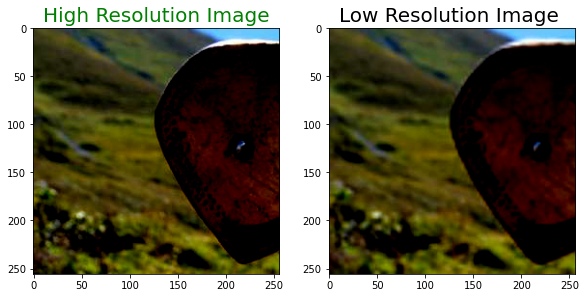

In [6]:
import numpy as np

plot_images(np.clip(high_images[45].reshape((256, 256, 3)), 0.0, 1.0), np.clip(low_images[45].reshape((256, 256, 3)), 0.0, 1.0))

#AutoEncoder

In [7]:
import tensorflow as tf

input = tf.keras.layers.Input(shape=(256, 256, 3))

# Input Size = 256 x 256 x 3 (G-1)
l1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(input)
l2 = tf.keras.layers.Activation("relu")(l1)
l3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l2)
l4 = tf.keras.layers.Activation("relu")(l3)
l5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l4)

# Input Size = 128 x 128 x 32 (G-2)
l6 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l5)
l7 = tf.keras.layers.Activation("relu")(l6)
l8 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l7)
l9 = tf.keras.layers.Activation("relu")(l8)
l10 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l9)

# Input Size = 64 x 64 x 64 (G-3)
l11 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l10)
l12 = tf.keras.layers.Activation("relu")(l11)
l13 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Activation("relu")(l13)
l15 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l14)

# Input Size = 32 x 32 x 128
encoder_output = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

# Input Size = 32 x 32 x 256 (G-1)
l16 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(encoder_output)
l17 = tf.keras.layers.Activation("relu")(l16)
l18 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l17)
l19 = tf.keras.layers.Activation("relu")(l18)

# Residual Connection
l20 = tf.keras.layers.add([l19, l14])

# Input Size = 64 x 64 x 128 (G-2)
l21 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l20)
l22 = tf.keras.layers.Activation("relu")(l21)
l23 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l22)
l24 = tf.keras.layers.Activation("relu")(l23)

# Residual Connection
l25 = tf.keras.layers.add([l24, l9])

# Input Size = 128 x 128 x 64 (G-2)
l26 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l25)
l27 = tf.keras.layers.Activation("relu")(l26)
l28 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l27)
l29 = tf.keras.layers.Activation("relu")(l28)

# Residual Connection
l30 = tf.keras.layers.add([l29, l4])

# Input Size = 256 x 256 x 32
l31 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), kernel_initializer="he_uniform", padding="same", activity_regularizer=tf.keras.regularizers.l1(10e-10))(l30)
decoder_output = tf.keras.layers.Activation("relu")(l31)
# Output Size = 256 x 256 x 3

model = tf.keras.models.Model(inputs = [input], outputs = [decoder_output])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [9]:
# Perceptual Loss
def _vgg(output_layer):
    vgg = tf.keras.applications.VGG19(input_shape=(None, None, 3), include_top=False)
    return tf.keras.models.Model(vgg.input, vgg.layers[output_layer].output)

def vgg_54():
    return _vgg(20)

vgg = vgg_54()

# Loss Function
def content_loss(y_pred, y_true):
    y_true = tf.keras.applications.vgg19.preprocess_input(y_true)
    y_pred = tf.keras.applications.vgg19.preprocess_input(y_pred)
    y_true_features = vgg(y_true) / 12.75
    y_pred_features = vgg(y_pred) / 12.75
    return tf.keras.losses.mean_squared_error(y_pred_features, y_true_features)

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/chkp/LTH_autoencoder.h5",
                                              monitor="val_loss",
                                              mode="min",
                                              save_best_only=True,
                                              verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 min_delta=0,
                                                 patience=3,
                                                 verbose=1,
                                                 restore_best_weights=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs")
callbacks = [earlystopping, checkpoint, tensorboard]

In [11]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    verbose=1,
                    callbacks=callbacks,
                    )

Epoch 1/50
337/337 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.6404
Epoch 1: val_loss improved from inf to 0.00632, saving model to /content/chkp/LTH_autoencoder.h5
337/337 [==============================] - 240s 690ms/step - loss: 0.0729 - accuracy: 0.6404 - val_loss: 0.0063 - val_accuracy: 0.7638
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.8442
Epoch 2: val_loss improved from 0.00632 to 0.00490, saving model to /content/chkp/LTH_autoencoder.h5
337/337 [==============================] - 231s 687ms/step - loss: 0.0052 - accuracy: 0.8442 - val_loss: 0.0049 - val_accuracy: 0.8692
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.8698
Epoch 3: val_loss improved from 0.00490 to 0.00444, saving model to /content/chkp/LTH_autoencoder.h5
337/337 [==============================] - 234s 694ms/step - loss: 0.0045 - accuracy: 0.8698 - val_loss: 0.0044 - val_accuracy: 0.8446
Epoch 4/

#Plotting

In [15]:
import matplotlib.pyplot as plt

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

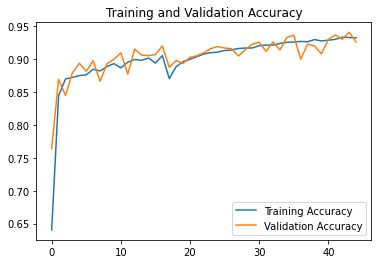

In [16]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

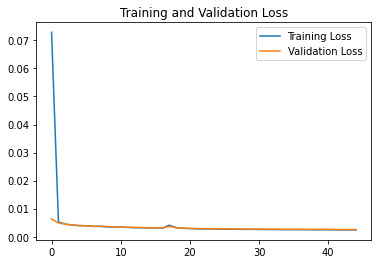

In [17]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model_ =  tf.keras.models.load_model("/content/chkp/LTH_autoencoder.h5", compile=True)

In [18]:
loss, accuracy = model_.evaluate(test_generator)

21/21 [==============================] - 8s 347ms/step - loss: 0.0025 - accuracy: 0.9358


In [19]:
import matplotlib.pyplot as plt

# defining function to plot images pair
def plot_images(hrimage, lrimage, predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(hrimage)
    plt.subplot(1,3,2)
    plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(lrimage)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'black', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

In [49]:
low_res_images, high_res_images = next(test_generator)

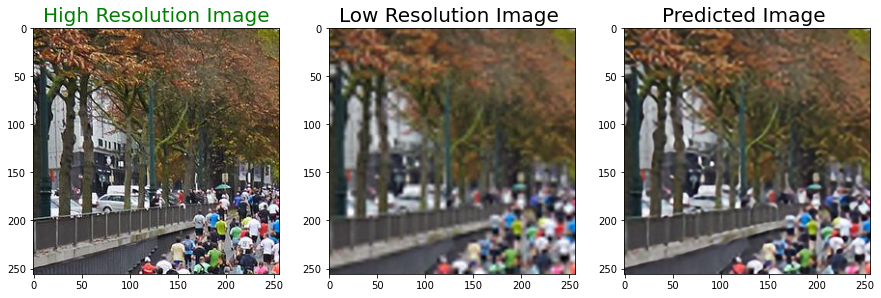

In [51]:
import numpy as np
import random

idx = random.randint(0, len(low_res_images))
high_res_image = np.clip(high_res_images[idx].reshape((256, 256, 3)), 0.0, 1.0)
low_res_image = np.clip(low_res_images[idx].reshape((256, 256, 3)), 0.0, 1.0)
predictable = low_res_images[idx].reshape(-1, 256, 256, 3)
predicted = model_.predict(predictable)
predicted = np.clip(predicted , 0.0, 1.0)
predicted_image = predicted.reshape(256, 256, 3)
plot_images(high_res_image, low_res_image, predicted_image)

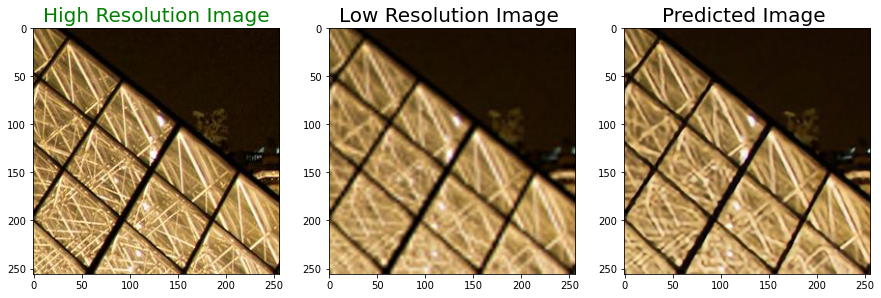

In [54]:
import numpy as np
import random

idx = random.randint(0, len(low_res_images))
high_res_image = np.clip(high_res_images[idx].reshape((256, 256, 3)), 0.0, 1.0)
low_res_image = np.clip(low_res_images[idx].reshape((256, 256, 3)), 0.0, 1.0)
predictable = low_res_images[idx].reshape(-1, 256, 256, 3)
predicted = model_.predict(predictable)
predicted = np.clip(predicted , 0.0, 1.0)
predicted_image = predicted.reshape(256, 256, 3)
plot_images(high_res_image, low_res_image, predicted_image)

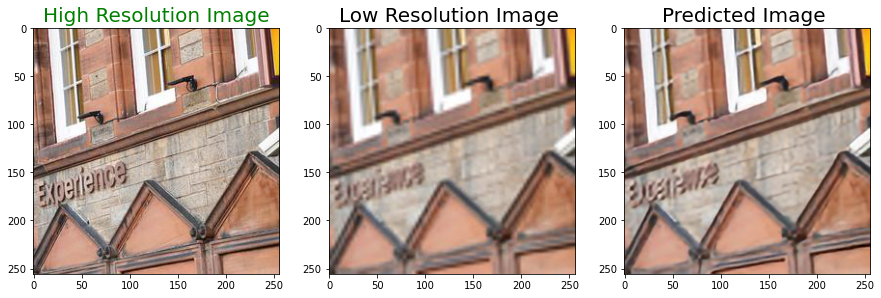

In [55]:
import numpy as np
import random

idx = random.randint(0, len(low_res_images))
high_res_image = np.clip(high_res_images[idx].reshape((256, 256, 3)), 0.0, 1.0)
low_res_image = np.clip(low_res_images[idx].reshape((256, 256, 3)), 0.0, 1.0)
predictable = low_res_images[idx].reshape(-1, 256, 256, 3)
predicted = model_.predict(predictable)
predicted = np.clip(predicted , 0.0, 1.0)
predicted_image = predicted.reshape(256, 256, 3)
plot_images(high_res_image, low_res_image, predicted_image)

#Implemented By Muhamma Hanan Asghar